## Some preliminary steps: Includes, Hardware support. 

In [2]:
%run librairiesCNN.py

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


## Load network ensemble

In [2]:
from CNN_architectures import StreaksCNN

file_net = 'networks/network_grayscale_gradient_uniformDisp_n=1M'
h5f = h5py.File(('%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
n_ensemble_members = h5f['n_ensemble_members'][()]
filter_size = h5f['filter_size'][()]
padding = h5f['padding'][()]
h5f.close()

net_ensemble = []
for n in range(n_ensemble_members):
    f_output_name = '%s_%d.pytorch' % (file_net, n)
    net_ensemble.append(StreaksCNN(winSz = windowSize, \
                                   filtSz = filter_size, \
                                   convPad = padding))
    
    net_ensemble[n].load_state_dict(torch.load('%s_%d.pytorch' % (file_net, n), map_location = device))
    net_ensemble[n].to(device)
    net_ensemble[n].eval()
    
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

CNN_width=windowSize
CNN_height=windowSize
overlap=24

## Load experimental image

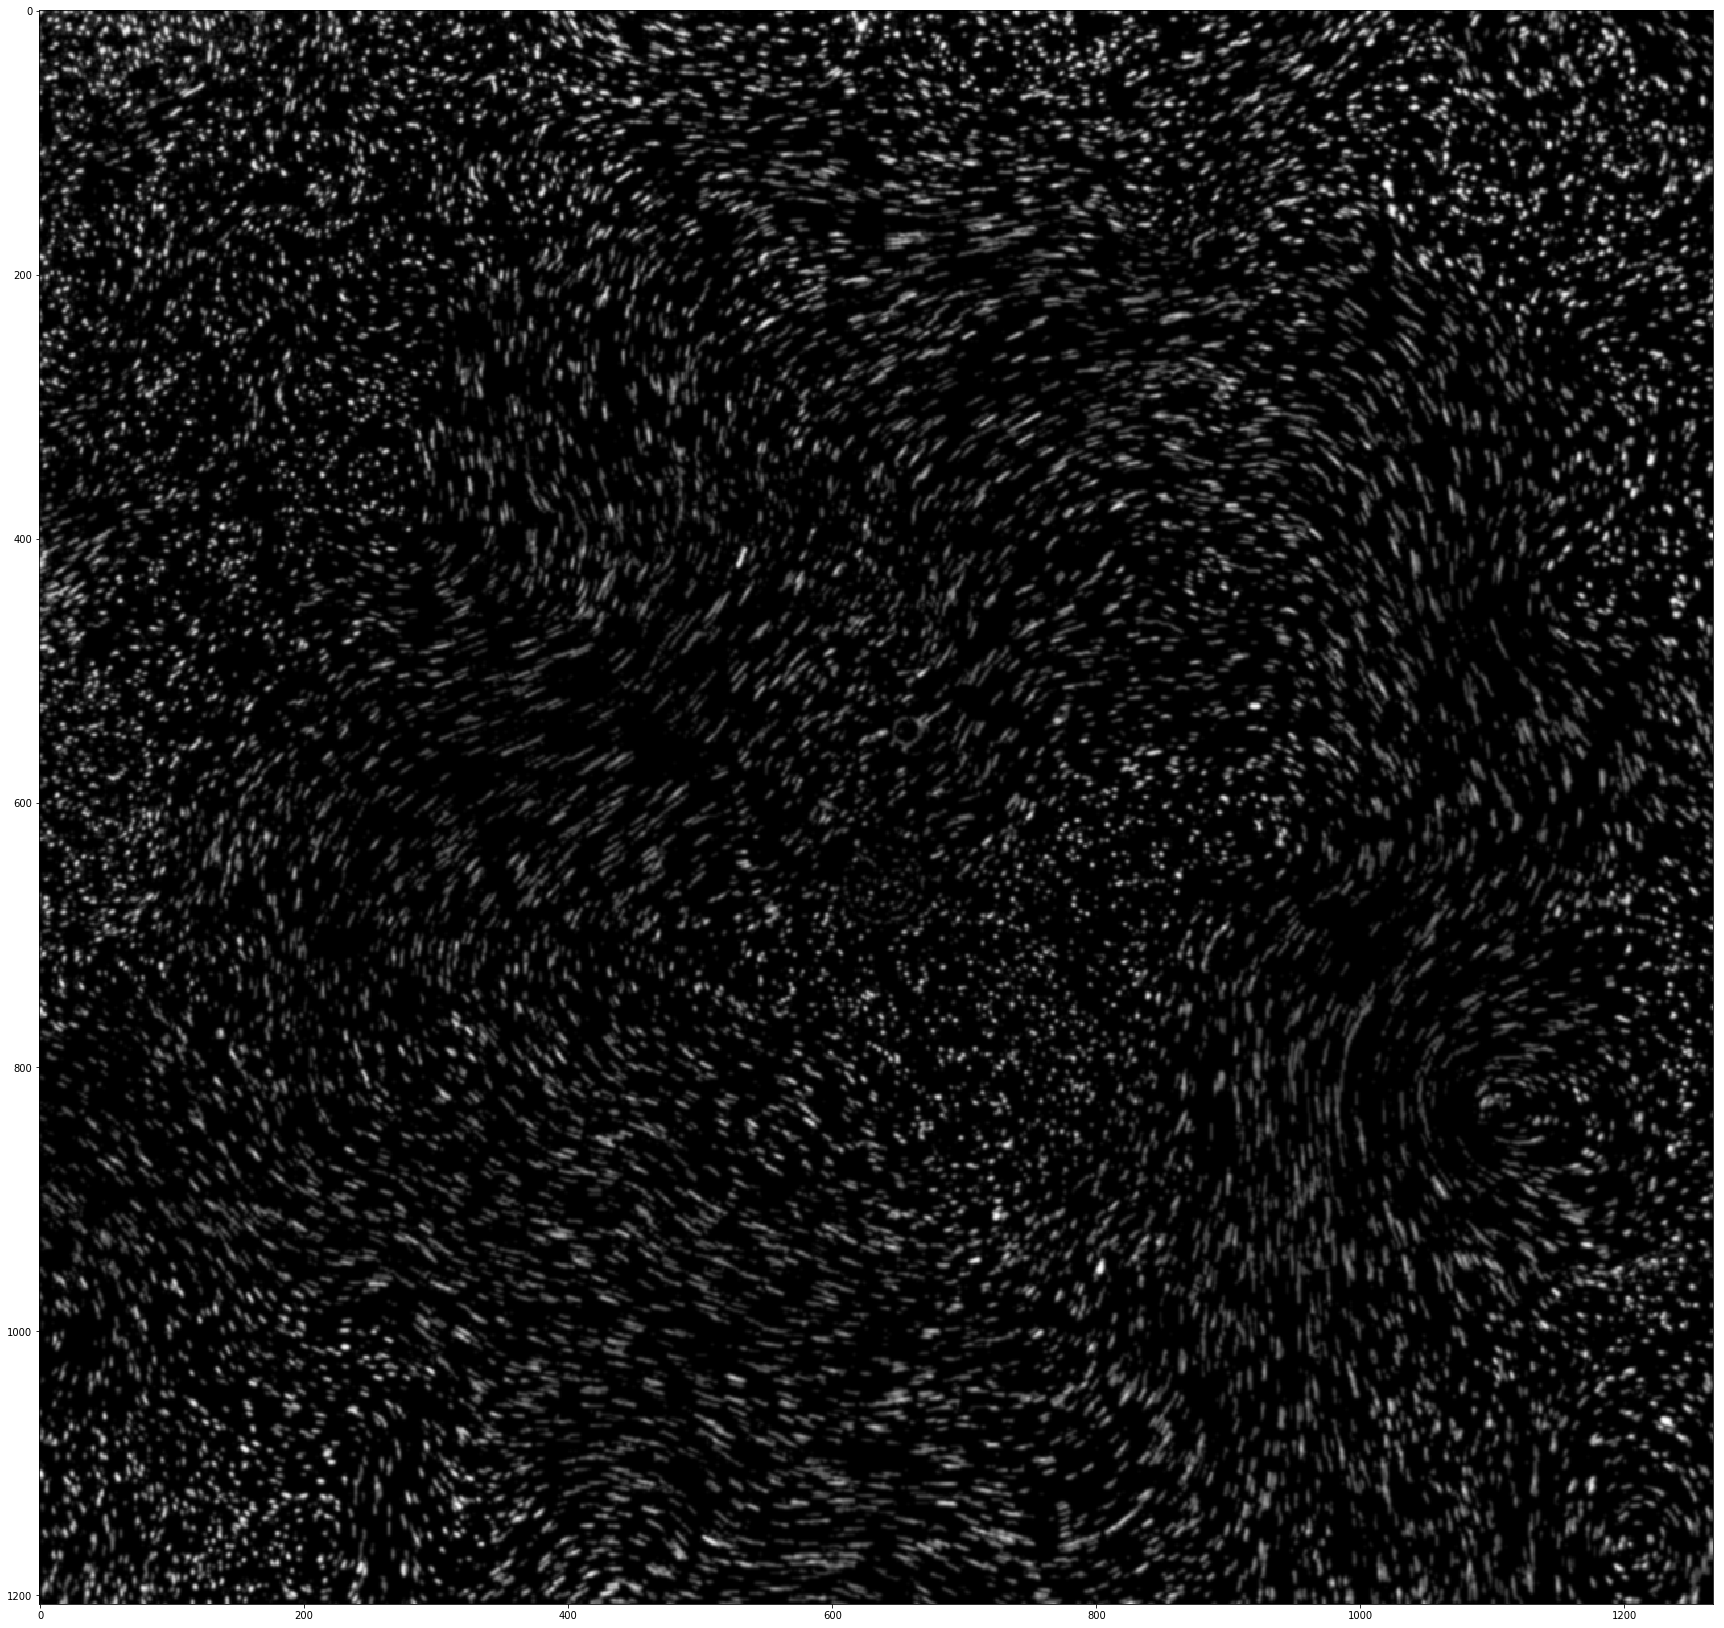

In [3]:
#imageFile='data/Test_image_experiment.jpg'
imageFile1='data/experiment_frame_A.jpg'
imageFile2='data/experiment_frame_B.jpg'
image1=Image.open(imageFile1).convert('L')
image2=Image.open(imageFile2).convert('L')
# The background needs to be removed due to CCD matrix jitter. 
# We use here a threshold value below which all points are set to black.

threshold = 50
data = np.array(image1.getdata())
data[data < threshold] = 0
image1.putdata(data)

# After Thresholding we apply a Gaussian Filter to avoid abrupt
im = image1.filter(ImageFilter.GaussianBlur(radius = 1))

figure(figsize=(30,30))
imshow(im, cmap='gray',vmin=0,vmax=255)

## Testing different rescaling on a single interrogationWindows 
The interrogation window's size is fixed to 48x48, depending on the seeding's density, the size of the particles, the flow speed and the camera resolution, it may be necessary to resize the image. Although resizing may help, it is wise to perform the experiment in conditions as close as possible from the training of the network. You aim at:

    -2 to 10 streaks per image.
    -streak thickness ~ particle radius ~ 2 to 4px
    -max displacement ~24px
    
In order to decide if rescaling is beneficial, we perform a test on few randomly chosen interrogation windows from the image. 0.5->image size / 2,  1.5->image size x 1.5, 
    



Testing finished, took 0.0539s. 185.45 images/sec.
Testing finished, took 0.0300s. 333.14 images/sec.
Testing finished, took 0.0245s. 407.87 images/sec.


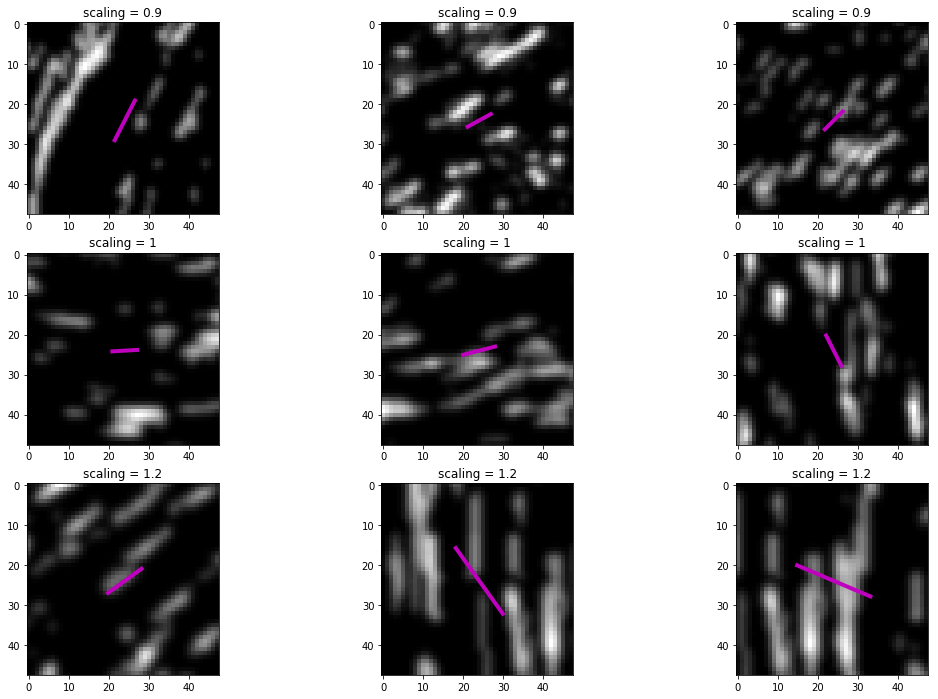

In [4]:
scaling=[0.9,1,1.2]
nTestSubwindows=3

interrogationWindows=np.empty(shape=(len(scaling),nTestSubwindows,1,\
                                     CNN_width,CNN_height))
imagesTOprocess=np.empty(shape=(nTestSubwindows,1,\
                                     CNN_width,CNN_height))
results=[]
count=0
for i in range(len(scaling)):
    newImageSize=(int(im.size[0]*scaling[i]),int(im.size[1]*scaling[i]))
    _imResized=im.resize(newImageSize,Image.ANTIALIAS)
    _x,_y,splittedImages,_,_ =\
    splitImage(np.array(_imResized),CNN_width,CNN_height,overlap)
    indices = random.randint(0, len(splittedImages), nTestSubwindows)
    for j in range(indices.size):
        interrogationWindows[i,j,0,:,:]=np.array(Image.fromarray(\
                                    splittedImages[indices[j],:,:]))
        
        count+=1

for i in range(len(scaling)):
    imagesTOprocess[:,0,:,:]=interrogationWindows[i,:,0,:,:]

    inputs = torch.from_numpy(np.array(imagesTOprocess) / 255).type(torch.FloatTensor)
    inputs = inputs.to(device)
    
    prediction=np.zeros((n_ensemble_members,imagesTOprocess.shape[0],2))
    averagedPrediction=np.zeros((imagesTOprocess.shape[0],2))

    start_time=time.time()
    for n in range(n_ensemble_members):
        net = net_ensemble[n]
        net.eval()

        net_outputs = net(inputs)
        if 'cuda' in device.type:
            net_outputs = net_outputs.cpu()

        prediction[n,:,:]=scaler.inverse_transform(net_outputs.data.numpy())
        averagedPrediction += prediction[n,:,:]

    elapsed_time = time.time() - start_time
    print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                                n_ensemble_members / elapsed_time))

    averagedPrediction /= n_ensemble_members
    results.append(np.array(averagedPrediction))

results=np.array(results)       

fig=figure()   
count=1
for i in range(len(scaling)):
    for j in range(indices.size):
        ax = fig.add_subplot(nTestSubwindows,len(scaling),count)
        count+=1
        imshow(interrogationWindows[i,j,0,:,:],cmap='gray')
        ax.set_title('scaling = {}'.format(scaling[i]))
        displacement=results[i,j,0]
        angle=results[i,j,1]
    
        xc = CNN_width / 2
        yc = CNN_height / 2

        x0 = xc - math.cos(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.
        x1 = xc + math.cos(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.

        y0 = yc - math.sin(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.
        y1 = yc + math.sin(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.

        xy = np.array(([x0, y0], [x1, y1]));

        line = patches.Polygon(xy, color = 'm', linewidth = 4)

        ax.add_patch(line)

fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
show()

## Apply network ensemble to the entire image

Based on the previous tests, resize the whole image before applying the Convolution Network. You have two choices:

    1-applyEnsenble=True: Uses the N trained networks.
    2-applyEnsenble=False: Use only one of the N networks.
    
The first option takes longer but allows one to to estimate uncertainties

In [5]:
# Rescaling of the image:
scaling=1.
applyEnsemble=True
# Which Network of the ensemble if applyEnsemble=False
n=3 
overlap=24

newImageSize=(int(im.size[0]*scaling),int(im.size[1]*scaling))
imResized=im.resize(newImageSize,Image.ANTIALIAS)
    
start_time=time.time()
_x,_y,splittedImages,nh,nw =splitImage(np.array(imResized),CNN_width,CNN_height,\
                                       overlap)

#reshape the data to match the CNN format filter
imagesTOprocess = np.zeros([ splittedImages.shape[0],1, splittedImages.shape[1], \
                            splittedImages.shape[2]], dtype=np.float32)
imagesTOprocess[:,0,:,:]=splittedImages[:,:,:]
elapsed_time = time.time() - start_time
print("Splitting took {:.4f}s.".format(elapsed_time))

ximage = torch.from_numpy(imagesTOprocess / 255).type(torch.FloatTensor)

params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

input_dataset = TensorDataset(ximage)
input_loader = DataLoader(input_dataset, **params)

prediction=np.zeros((n_ensemble_members,imagesTOprocess.shape[0],2))
predictionSingle=np.zeros((imagesTOprocess.shape[0],2))
averagedPrediction=np.zeros((imagesTOprocess.shape[0],2))
stdPrediction=np.zeros((imagesTOprocess.shape[0],2))
displacement=np.zeros((imagesTOprocess.shape[0]))
angle=np.zeros((imagesTOprocess.shape[0]))
stdDisplacement=np.zeros((imagesTOprocess.shape[0]))
stdAngle=np.zeros((imagesTOprocess.shape[0]))

start_time=time.time()
if applyEnsemble:
    print('Processing with Ensemble')
    for n in range(n_ensemble_members):
        net = net_ensemble[n]
        net.eval()
        
        ypredicted = np.empty(shape=(0,2))
        for inputs in input_loader:
            inputs = inputs[0].to(device)
            
            # Forward pass
            net_outputs = net(inputs)
    
            if 'cuda' in device.type:
                net_outputs = net_outputs.cpu()
    
            ypredicted = np.concatenate((ypredicted, net_outputs.data.numpy()))
        
        prediction[n,:,:]=scaler.inverse_transform(ypredicted)

    elapsed_time = time.time() - start_time
    print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                                n_ensemble_members / elapsed_time))

    averagedPrediction=np.mean(prediction, axis=0)
    stdPrediction=np.std(prediction, axis=0)
    
    displacement=np.reshape(averagedPrediction[:,0],(nh,nw))
    stdDisplacement=np.reshape(stdPrediction[:,0],(nh,nw))
    angle=np.reshape(averagedPrediction[:,1],(nh,nw))
    stdAngle=np.reshape(stdPrediction[:,1],(nh,nw))
else:
    print('Processing with only network #: {}'.format(n))        
    net = net_ensemble[n]
    net.eval()
    # Forward pass
    net_outputs = net(inputs)
    if 'cuda' in device.type:
        net_outputs = net_outputs.cpu()

    predictionSingle=scaler.inverse_transform(val_outputs.data.numpy())
    elapsed_time = time.time() - start_time
    print("Testing finished, took {:.4f}s.".format(elapsed_time))

    displacement = np.reshape(predictionSingle[:,0], (nh,nw))
    angle = np.reshape(predictionSingle[:,1], (nh,nw))
    
x = np.reshape(np.array(_x), (nh,nw))
y = np.reshape(np.array(_y), (nh,nw))

Splitting took 0.1078s.
Processing with Ensemble
Testing finished, took 6.0071s. 1.66 images/sec.


## Plot final results

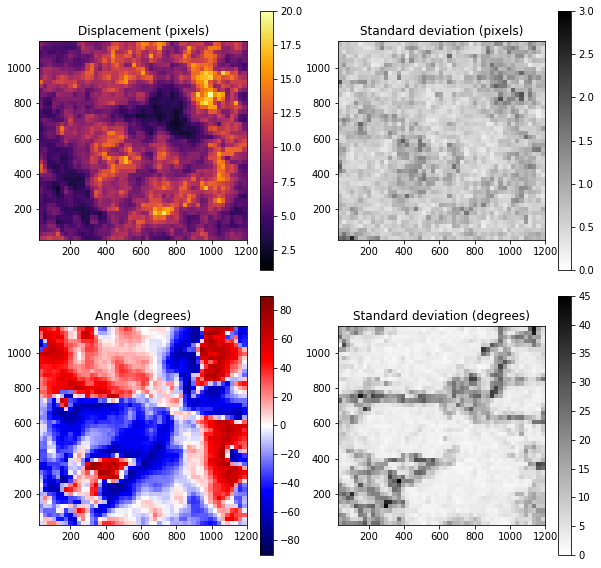

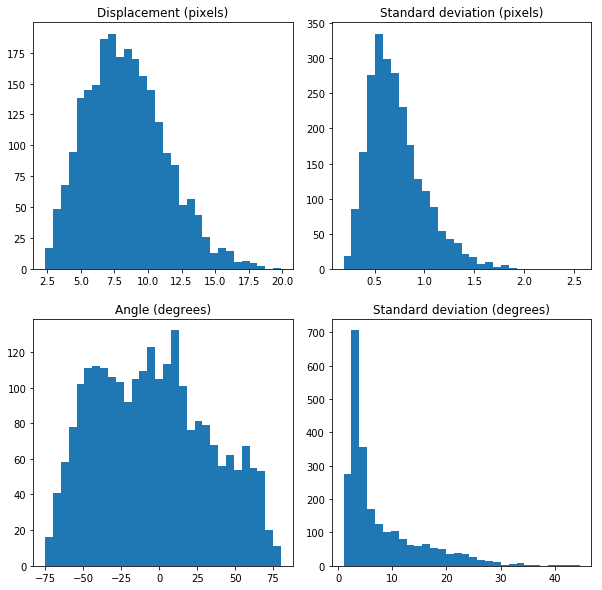

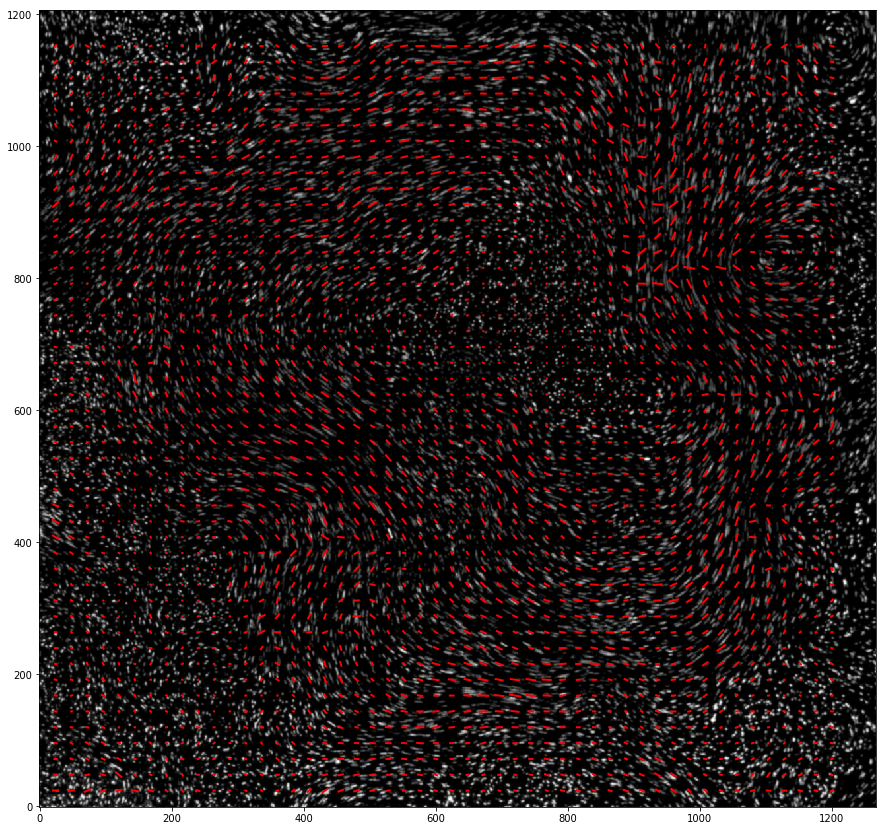

In [11]:
figure(figsize=(10,10))

subplot(2,2,1)
pcolormesh(x, y, displacement,vmin=1, vmax=20, cmap='inferno')
colorbar()
title('Displacement (pixels)')
axis('scaled')

subplot(2,2,2)
pcolormesh(x, y, stdDisplacement, vmin=0, vmax=3, cmap='gray_r')
colorbar()
title('Standard deviation (pixels)')
axis('scaled')

subplot(2,2,3)
pcolormesh(x,y,angle,vmin=-90, vmax=90, cmap='seismic')
colorbar()
title('Angle (degrees)')
axis('scaled')

subplot(2,2,4)
pcolormesh(x,y,stdAngle,vmin=0, vmax=45, cmap='gray_r')
colorbar()
title('Standard deviation (degrees)')
axis('scaled')

subplots_adjust(hspace=0.1, wspace = 0.15)
savefig('paper/figs/figure8a.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)

figure(figsize=(10,10))
subplot(2,2,1)
hist(displacement.flatten(),30)
title('Displacement (pixels)')
subplot(2,2,2)
hist(stdDisplacement.flatten(),30)
title('Standard deviation (pixels)')
subplot(2,2,3)
hist(angle.flatten(),30)
title('Angle (degrees)')
subplot(2,2,4)
hist(stdAngle.flatten(),30)
title('Standard deviation (degrees)')

subplots_adjust(hspace=0.2, wspace = 0.15)
savefig('paper/figs/figure8b.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)

fig=figure(figsize=(10,10))
imshow(np.array(imResized),origin='lower')
gray()
ax=fig.add_subplot(1,1,1)

x0 = _x - np.cos(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.
x1 = _x + np.cos(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.

y0 = _y - np.sin(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.
y1 = _y + np.sin(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.

xy = np.array(([x0, y0], [x1, y1]))
for i in range(0,xy.shape[2]):
        line=patches.Polygon(xy[:,:,i], color = 'r', linewidth = 2)
        ax.add_patch(line)

fig.set_size_inches(np.array(fig.get_size_inches()) * 1.5)
savefig('paper/figs/figure9.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)

show()

Plot FFT of the kinetic energy of the flow

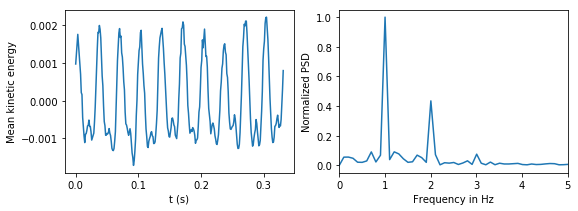

In [20]:
import scipy.signal as sp
fileName='./data/21ms30fps.h5'
data=h5py.File(fileName,'r')
t=np.arange(data['energyCNN'][:].shape[0])/30
s=data['energyCNN'][:]
data.close()

fs=30.
s=sp.detrend(s)
sFFT = np.fft.fft(s);
sFREQ = np.fft.fftfreq(len(t),1/fs)
Nfreq = round(len(sFREQ)/2)
freqs = sFREQ[0:Nfreq]
psd = np.abs(sFFT)[0:Nfreq]

figure(figsize=(9,3))
subplot(1,2,1)
plot(t/fs,s)
xlabel('t (s)')
ylabel('Mean kinetic energy')
subplot(1,2,2)
plot(freqs, psd / psd.max())
xlim((0,5))
xlabel('Frequency in Hz')
ylabel('Normalized PSD')
savefig('paper/figs/figure10.png', dpi=150, format='png', bbox_inches='tight', pad_inches=0)